In [3]:
# Imports
import os
import sys

ROOT_DIR = os.getcwd()[:os.getcwd().rfind('quantum_HEOM')] + 'quantum_HEOM'
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

import numpy as np
from scipy import constants as c

from quantum_heom import figures as figs
from quantum_heom import metadata as meta
from quantum_heom import utilities as util
from quantum_heom.quantum_system import QuantumSystem

# Defining the System

After familiarising yourself with the unit system used, a ``QuantumSystem`` object can be defined with your choice of parameters. All the parameters, with conditions and examples of possible values are given:

* ``'sites'`` : int
    * The number of chromophore sites in the system. 
    * For the FMO complex, the number of sites must be set to 7.
    * When using a ``'spin-boson'`` system Hamiltonian, the number of sites must be 2.
    
    
* ``'init_site_pop'`` : list
    * The sites populations of the density matrix in which to put a share of the initial excitation.
    * If localising the excitation on site 1, for example, pass ``[1]``
    * Specifying two or more sites creates a superposition initial state
        * e.g. ``[1, 3]`` places values of 0.5 in site populations $\rho_{11}$ and $\rho_{33}$ (normalised so that $\rho$ remains trace one), as well as in coherences $\rho_{13}$ and $\rho_{31}$
        

* ``'interaction_model'`` : str
    * The model that defines the form of system Hamiltonian.
    * ``'spin-boson'``, for 2-site systems only; $H_{\text{sys}} = \frac{\epsilon}{2} \sigma_z + \frac{\Delta}{2} \sigma_x$, where $\epsilon$ is the difference in site energies and $\Delta$ is the tunneling strength
    * ``'FMO'``, for 7-site systems only.


* ``'epsi_delta'`` : tuple of float
    * The values for the difference in site energies, $\epsilon$, and tunneling strength $\Delta$ used in the constructing the ``'spin-boson'`` system Hamiltonian
    * To set $\epsilon = 20$ rad ps$^{-1}$ and  $\Delta = 40$ rad ps$^{-1}$, pass the tuple ``(20.0, 40.0)``
    
    
* ``'dynamics_model'`` : str
    * The model used to describe the bath relaxation dynamics.
    * For the Lindblad models, choose from ; ``'local dephasing lindblad'``, ``'global thermalising lindblad'``, or ``'local thermalising lindblad`''
    * For HEOM (only applicable for 2-site systems, with ``'interaction_model'``: ``'spin-boson'``, and the Debye spectral density) set as ``'HEOM'``
    
   
* ``'time_interval'`` : float
    * The timestep interval between evaluations of the density matrix, in units of femtoseconds
    * For instance ``'time_interval'``: ``5.0`` sets the time interval to 5 fs
    
    
* ``'timesteps'`` : int
    * The number of timesteps at which to evaluate the density matrix (separated in time by the value set for ``'time_interval'``)
    * Example; ``'timesteps'``: ``500``
    
    
* ``'temperature'`` : float
    * The temperature to set the bath at (in Kelvin), i.e. ``300.0`` corresponds to physiological temperature (300 Kelvin)
    
    
* ``'deph_rate'`` : float
    * The dephasing rate, $\Gamma_{\text{deph}}$, used as the rate constant in the ``'local dephasing lindblad'`` model, as well as the value of the Redfield rate constant at zero frequency, i.e. $k(\omega=0) = \Gamma_{\text{deph}}$ for the expression below.
    * The Redfield rate constant is given by: $k(\omega) = 2[(1 + n_{\text{BE}}(\omega))J(\omega) + n(-\omega)J(-\omega)]$
    
    
* ``'cutoff_freq'`` : float
    * The value for the cutoff frequency, $\omega_c$, used in the evaluation of the Debye and Ohmic spectral densities (see below).
    
    
* ``'reorg_energy'`` : float
    * The value for the reorganisation energy, $\lambda$, used in the evaluation of the Debye and Ohmic spectral densities (see below).
    
    
* ``'spectral_density'`` : str
    * The spectral density to use to describe the system-bath interaction.
    * ``'debye'`` has the form $J(\omega) = 2 \lambda \frac{\omega \omega_c}{\omega^2 + \omega_c^2}$
    * ``'ohmic'``; $J(\omega) = \pi \lambda \frac{\omega}{\omega_c} \exp (- \frac{\omega}{\omega_c})$
    * ``'renger-marcus'``; a parametrised form, given in [T. Renger and R. A. Marcus, *Journal of Chemical Physics*, 2002, **116**, 9997–10019](https://aip.scitation.org/doi/abs/10.1063/1.1470200?casa_token=nW56Fs4FopUAAAAA:ew8Nw8GFojKRfpDxvySiu1ZiwwmG1Rth2giYfJgi04HDObgc9YcTAcfSpNnkvcvc9YHLN-sNwm6d)
    
    
* ``'matsubara_terms'`` : int
    * Only needs to be specified if ``'dynamics_model'`` used is ``'HEOM'``
    * The number of exponential terms to include in the evaluation of the correlation function, i.e. ``5``
    * Also denoted $K$ in the literature.
    * Correlation function used in HEOM given by; $C(t>0) = \sum_k^K c_k \exp(-\nu_k t)$
    
    
* ``'matsubara_coeffs'`` : list
    * Only needs to be specified if ``'dynamics_model'`` used is ``'HEOM'``
    * A list of the matsubara coefficients, $c_k$, in descending order, used in evaluation of the above correlation function.
    * If passed as ``None``, QuTiP's HEOM Solver class automatically generates them.
    
    
* ``'matsubara_frequencies'`` : list
    * Only needs to be specified if ``'dynamics_model'`` used is ``'HEOM'``
    * A list of the matsubara frequencies, $\nu_k$, in ascending order.
    * If passed as ``None``, QuTiP's HEOM Solver class automatically generates them.
    
    
* ``'bath_cutoff'`` : int
    * Only needs to be specified if ``'dynamics_model'`` used is ``'HEOM'``
    * The number of bath terms to include, i.e. ``20``
    * Otherwise known as the hierarchy truncation level, $N_c$
    
    
An example using these parameters for defining a system described by HEOM dynamics is shown below.

## Example

In [6]:
args1 = {'sites': 2,
         'init_site_pop': [1],
         'interaction_model': 'spin-boson',
         'epsi_delta': (20, 40),             # rad ps^-1
         'dynamics_model': 'HEOM',
         'time_interval': 5.0,               # fs
         'timesteps': 500,
         'temperature': 300.0,               # K
         'cutoff_freq': 6.0,                 # rad ps^-1
         'reorg_energy': 6.0,                # rad ps^-1
         'spectral_density': 'debye',
         'matsubara_terms': 4,
         'matsubara_coeffs': None,
         'matsubara_freqs': None,            # rad ps^-1
         'bath_cutoff': 10
        }

q1 = QuantumSystem(**args1)

The attributes of a ``QuantumSystem`` object can be accessed at any time by called the ``__dict__`` attribute:

In [8]:
q1.__dict__

{'_sites': 2,
 '_init_site_pop': [1],
 '_interaction_model': 'spin-boson',
 '_epsi_delta': (20, 40),
 '_dynamics_model': 'HEOM',
 '_time_interval': 5.0,
 '_timesteps': 500,
 '_temperature': 300.0,
 '_cutoff_freq': 6.0,
 '_reorg_energy': 6.0,
 '_spectral_density': 'debye',
 '_matsubara_terms': 4,
 '_matsubara_coeffs': None,
 '_matsubara_freqs': None,
 '_bath_cutoff': 10}

# Plotting Dynamics

The possible values for each of the arguments used to plot the dynamics are listed here.

* ``'elements'`` : str, or list of str
    * a string of ``'all'`` (plots all elements), ``'diagonals'`` (plots only diagonals, or ``'off-diagonals'`` (only off-diagonals).
    * a list of density matrix elements in string format; i.e. to plot elements $\rho_{11}$ and $\rho_{21}$, the list ``['11', '21']`` should be passed.
    * ``None``, plots none of the density matrix elements. Can be used if only wanting to plot a ``trace_measure`` (see below).
     
     
* ``'coherences'`` : str, or list of str
    * either ``'imag'`` to plot the imaginary parts of the coherences, ``'real'`` to plot the real, or a list of both ``['imag', 'real']`` to plot both contributions.
      

* ``'trace_measure'`` : str, or list of str
    * ``'squared'`` to plot the trace of the density matrix squared, $\text{tr} (\rho (t)^2)$ at each timestep; a measure of the purity of the quantum state
    * ``'distance'`` to plot the trace distance of the state at each timestep with respect to the **canonical** thermal state, $D(\rho (t), \rho_{\text{canon}}) = 0.5 \text{tr} | \rho (t) - \rho_{\text{canon}} |$
    
    
* ``'asymptote'`` : bool 
    * either ``True``, which plots a horizontal asymptote at a value of $1/N$ (useful for seeing the population of all sites in the maximally mixed state), or ``False``
    
    
* ``'view_3d'`` : bool
    * either ``True``, which plots the dynamics figure in 3D, or ``False``, which does so in 2D.
    
    
* ``'save'`` : bool
    * either ``True``, which saves the figure into the ``quantum\_HEOM/doc/figures`` relative path on your local drive with a descriptive filename, or ``False``, which doesn't.

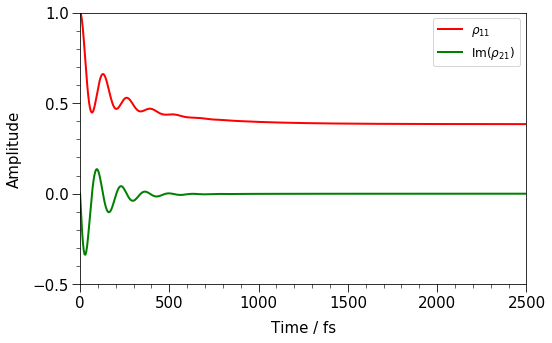

In [10]:
plot_args = {'elements': ['11', '21'], 
             'coherences': ['imag'], 
             'trace_measure': [None], 
             'asymptote': False, 
             'view_3d': False, 
             'save': False}


figs.plot_dynamics(q1, **plot_args)

Notice that when ``q1.__dict__`` is called now, the ``'_matsubara_coeffs'`` and ``'matsubara_freqs'``, that were originally set to ``None``, have been assigned values. This is because the ``QuantumSystem`` objetc has been passed through QuTiP's HEOM solver upon using the ``figs.plot_dynamics(...)`` method.

In [11]:
q1.__dict__

{'_sites': 2,
 '_init_site_pop': [1],
 '_interaction_model': 'spin-boson',
 '_epsi_delta': (20, 40),
 '_dynamics_model': 'HEOM',
 '_time_interval': 5.0,
 '_timesteps': 500,
 '_temperature': 300.0,
 '_cutoff_freq': 6.0,
 '_reorg_energy': 6.0,
 '_spectral_density': 'debye',
 '_matsubara_terms': 4,
 '_matsubara_coeffs': array([470.3961199 -36.j,  22.93186762 +0.j,  11.46084963 +0.j,
          7.63993907 +0.j]),
 '_matsubara_freqs': array([  6.        , 246.77894367, 493.55788733, 740.336831  ]),
 '_bath_cutoff': 10}

# Next steps

Now that the parameters have been defined and possible values demonstrated, some examples will be considered in the next [tutorial]()